**Import necessary libraries**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
import torch.optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from PIL import Image
import glob
import random
import cv2
import math
import argparse
import time
from skimage import io, img_as_float, filters
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import gaussian_filter

Download and unzip the dataset

In [ ]:
!gdown https://drive.google.com/file/d/1i66Au-A6rP9z4v8WwY8bLiFO7tFpgZNB/view?usp=share_link --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=1i66Au-A6rP9z4v8WwY8bLiFO7tFpgZNB
From (redirected): https://drive.google.com/uc?id=1i66Au-A6rP9z4v8WwY8bLiFO7tFpgZNB&confirm=t&uuid=37b536df-69a8-4082-b937-28cecaa1fbe7
To: /content/data.zip
100% 969M/969M [00:19<00:00, 50.9MB/s]


In [ ]:
!unzip -q data.zip

**Summary of the dataset:**

- ~1500 ground truth images in folder "ori_images", ~27K hazed images in folder "hazy_images" were obtained
- Each image in “orig_images” has a filename of the format “NYU2_x.jpg” where x is an integer.
- Each image in “hazy_images” has a filename of the format “NYU2_x_y_z” where x, y, and z are integers.
- For a given original image “NYU2_x.jpg”, the artificially generated hazy images are named “NYU2_x_y_z” for some y and z. There can be many hazy images corresponding to each original image.

**Define hyperparameters and paths using a class:**

In [ ]:
class Args:
  # Define the arguments as attributes of a class
  orig_images_path = "data/ori_images/"
  hazy_images_path = "data/hazy_images/"
  lr = 0.001
  weight_decay = 0.0001
  grad_clip_norm = 0.1
  num_epochs = 10
  snapshots_folder = "snapshots/"
  test_result = "results/"

In [ ]:
# Seed function for reproducibility
def seed_all(seed=1313):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

seed_all(1313)

**Data Loading & Preprocessing**

Split the dataset for training (80%), validation (10%) and testing (10%).

In [ ]:
# Preprocess
def preprocess(image_path):
    # Step 1: Open the image
    data = Image.open(image_path)
    # Step 2: Resize the image to the expected dimensions (480, 640)
    data = data.resize((480,640), Image.LANCZOS)
    # Step 3: Normalize the pixel values to [0, 1]
    data = (np.asarray(data)/255.0)
    # Step 4: Convert the numpy array to a PyTorch tensor and permute the dimensions
    data = torch.from_numpy(data).float()
    data = data.permute(2,0,1)

    return data # Fixed indentation

In [ ]:
class DehazeDataManager(Dataset):
	def __init__(self, ori_images_path, hazy_images_path, mode='train'):
		self.ori_images_path, self.hazy_images_path = ori_images_path, hazy_images_path
		self.train_list, self.val_list, self.test_list = self.train_valid_test_split()
		self.data_list = self.train_list if mode == 'train' else self.val_list if mode == 'val' else self.test_list
		print(f"Total {'training' if mode == 'train' else 'validation' if mode == 'val' else 'test'} examples:", len(self.data_list))

	def preprocess(self, image):
		data = preprocess(image)
		return data

	def __getitem__(self, index):
		data_orig_path, data_hazy_path = self.data_list[index]

		data_orig = self.preprocess(data_orig_path)
		data_hazy = self.preprocess(data_hazy_path)

		return data_orig, data_hazy

	def __len__(self):
		return len(self.data_list)

	def train_valid_test_split(self, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Get all hazy image filenames
		hazy_image_files = glob.glob(os.path.join(self.hazy_images_path, "*.jpg"))

    # Group hazy images by their corresponding original image key
		image_groups = {}
		for hazy_image in hazy_image_files:
			hazy_image = hazy_image.split("/")[-1]
			key = hazy_image.split("_")[0] + "_" + hazy_image.split("_")[1] + ".jpg"
			if key not in image_groups:
				image_groups[key] = []
			image_groups[key].append(hazy_image)

    # Split the keys into training, validation, and testing sets
		keys = list(image_groups.keys())
		random.shuffle(keys)

		train_split_index = int(len(keys) * train_ratio)
		val_split_index = train_split_index + int(len(keys) * val_ratio)

		train_keys = keys[:train_split_index]
		val_keys = keys[train_split_index:val_split_index]
		test_keys = keys[val_split_index:]

    # Generate lists for train, validation, and test sets
		def generate_image_list(keys):
			image_list = []
			for key in keys:
				for hazy_image in image_groups[key]:
					image_list.append([os.path.join(self.ori_images_path, key),
					                   os.path.join(self.hazy_images_path, hazy_image)])
			return image_list

		train_list = generate_image_list(train_keys)
		val_list = generate_image_list(val_keys)
		test_list = generate_image_list(test_keys)

		return train_list, val_list, test_list


**AOD-Net Model: Convolutional Neural Network (CNN)**

AODNet is a simple yet effective CNN architecture designed for image dehazing.

In [ ]:
class AODNet(nn.Module):
	def __init__(self):
		super(AODNet, self).__init__()
		self.relu = nn.ReLU(inplace=True)
		self.e_conv1 = nn.Conv2d(3, 3, 1, 1, 0, bias=True)
		self.e_conv2 = nn.Conv2d(3, 3, 3, 1, 1, bias=True)
		self.e_conv3 = nn.Conv2d(6, 3, 5, 1, 2, bias=True)
		self.e_conv4 = nn.Conv2d(6, 3, 7, 1, 3, bias=True)
		self.e_conv5 = nn.Conv2d(12, 3, 3, 1, 1, bias=True)

		# Apply weight initialization
		self._initialize_weights()

	def forward(self, x):
		x1 = self.relu(self.e_conv1(x))
		x2 = self.relu(self.e_conv2(x1))
		concat1 = torch.cat((x1,x2), 1)
		x3 = self.relu(self.e_conv3(concat1))
		concat2 = torch.cat((x2, x3), 1)
		x4 = self.relu(self.e_conv4(concat2))
		concat3 = torch.cat((x1,x2,x3,x4),1)
		x5 = self.relu(self.e_conv5(concat3))
		clean_image = self.relu((x5 * x) - x5 + 1)
		return clean_image

	# Define the weight initialization function to ensure the network starts training with appropriately set parameters
	def _initialize_weights(self):
		for module in self.modules():
			if isinstance(module, nn.Conv2d):
				nn.init.normal_(module.weight, 0.0, 0.02)
			elif isinstance(module, nn.BatchNorm2d):
				nn.init.normal_(module.weight, 1.0, 0.02)
				nn.init.constant_(module.bias, 0)


FSIM Metric:

In [ ]:
def fsim(img1, img2):
    def phase_congruency(img):
      # Calculate the phase congruency using a Sobel filter
      Gx = filters.sobel_h(img)
      Gy = filters.sobel_v(img)
      magnitude = np.sqrt(Gx**2 + Gy**2)
      return magnitude

    def gradient_magnitude(img):
      # Calculate the gradient magnitude using Sobel filters
      Gx = filters.sobel_h(img)
      Gy = filters.sobel_v(img)
      return np.sqrt(Gx**2 + Gy**2)

    # Convert images to grayscale if they are not already
    if len(img1.shape) == 3:
      img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    if len(img2.shape) == 3:
      img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Calculate phase congruency for both images
    PC1 = phase_congruency(img1)
    PC2 = phase_congruency(img2)

    # Calculate gradient magnitude for both images
    GM1 = gradient_magnitude(img1)
    GM2 = gradient_magnitude(img2)

    # Compute similarity between the phase congruency of the two images
    T1 = 0.85
    S_PC = (2 * PC1 * PC2 + T1) / (PC1**2 + PC2**2 + T1)

    # Compute similarity between the gradient magnitudes of the two images
    T2 = 160
    S_G = (2 * GM1 * GM2 + T2) / (GM1**2 + GM2**2 + T2)

    # Combine the two similarity measures
    alpha = 1
    FSIM_map = S_PC**alpha * S_G**(1-alpha)

    # Weight the FSIM map by the phase congruency of the reference image
    FSIM_index = np.sum(FSIM_map * np.maximum(PC1, PC2)) / np.sum(np.maximum(PC1, PC2))

    return FSIM_index

**Training the model**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BaseTrainer:
  def __init__(self, model, criterion, optimizer, train_loader, val_loader, scheduler):
    self.model = model
    self.criterion = criterion  #the loss function
    self.optimizer = optimizer  #the optimizer
    self.train_loader = train_loader  #the train loader
    self.val_loader = val_loader  #the valid loader
    self.scheduler = scheduler  # the learning rate scheduler

  def compute_fsim(self, img1, img2):
    return fsim(img1, img2)

  #the function to train the model in many epochs
  def fit(self, config):
    self.num_batches = len(self.train_loader)

    for epoch in range(config.num_epochs):
      print(f'Epoch {epoch + 1}/{config.num_epochs}')
      train_loss, train_ssim, train_fsim = self.train_one_epoch(config)
      val_loss, val_ssim, val_fsim = self.validate_one_epoch(config)

      # Save the model at the end of each epoch
      model_path = os.path.join(config.snapshots_folder, f"dehazer_epoch_{epoch}.pth")
      torch.save(self.model.state_dict(), model_path)

      print(f'{self.num_batches}/{self.num_batches} - train_loss: {train_loss:.4f} - train_ssim: {train_ssim:.4f} - train_fsim: {train_fsim:.4f} \
                - val_loss: {val_loss:.4f} - val_ssim: {val_ssim:.4f} - val_fsim: {val_fsim:.4f}')

      # Step the scheduler at the end of the epoch
      self.scheduler.step()  # Update learning rate

  #train in one epoch, return the train_loss
  def train_one_epoch(self, config):
    self.model.train()
    running_loss, total_ssim, total_fsim, count = 0.0, 0, 0, 0
    for i, (img_orig, img_haze) in enumerate(self.train_loader):
      img_orig, img_haze = img_orig.to(device), img_haze.to(device)
      self.optimizer.zero_grad()
      outputs = self.model(img_haze)
      loss = self.criterion(outputs, img_orig)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(self.model.parameters(), config.grad_clip_norm)
      self.optimizer.step()

      running_loss += loss.item()
      # Convert tensors to numpy arrays for SSIM and FSIM calculations
      img_orig_np = img_orig.cpu().permute(0, 2, 3, 1).detach().numpy()[0]
      clean_image_np = outputs.cpu().permute(0, 2, 3, 1).detach().numpy()[0]
      # Compute SSIM & FSIM
      ssim_value = ssim(img_orig_np, clean_image_np, multichannel=True, win_size=3, data_range=1.0)
      fsim_value = self.compute_fsim(img_orig_np, clean_image_np)
      total_ssim += ssim_value
      total_fsim += fsim_value
      count += 1

    train_loss = running_loss / self.num_batches
    train_ssim = total_ssim / count
    train_fsim = total_fsim / count
    return train_loss, train_ssim, train_fsim

  #evaluate on a loader and return the loss and accuracy
  def evaluate(self, loader, config):
    self.model.eval()
    running_loss, total_ssim, total_fsim, count = 0.0, 0, 0, 0
    with torch.no_grad():
      for img_orig, img_haze in loader:
        img_orig, img_haze = img_orig.to(device), img_haze.to(device)
        outputs = self.model(img_haze)
        loss = self.criterion(outputs, img_orig)
        running_loss += loss.item()

        # Convert tensors to numpy arrays for SSIM and FSIM calculations
        img_orig_np = img_orig.cpu().permute(0, 2, 3, 1).numpy()[0]
        clean_image_np = outputs.cpu().permute(0, 2, 3, 1).numpy()[0]
        # Compute SSIM & FSIM
        ssim_value = ssim(img_orig_np, clean_image_np, multichannel=True, win_size=3, data_range=1.0)
        fsim_value = self.compute_fsim(img_orig_np, clean_image_np)
        total_ssim += ssim_value
        total_fsim += fsim_value
        count += 1

    loss = running_loss / len(self.val_loader)
    avg_ssim = total_ssim / count
    avg_fsim = total_fsim / count
    return loss, avg_ssim, avg_fsim

  #return the val_acc, val_loss, be called at the end of each epoch
  def validate_one_epoch(self, config):
    val_loss, val_ssim, val_fsim = self.evaluate(self.val_loader, config)
    return val_loss, val_ssim, val_fsim


In [ ]:
# Create an instance of the Args class
config = Args()

if not os.path.exists(config.snapshots_folder):
    os.mkdir(config.snapshots_folder)
if not os.path.exists(config.test_result):
    os.mkdir(config.test_result)

# Create datasets
train_data = DehazeDataManager(config.orig_images_path, config.hazy_images_path, mode='train')
val_data = DehazeDataManager(config.orig_images_path, config.hazy_images_path, mode='val')
test_data = DehazeDataManager(config.orig_images_path, config.hazy_images_path, mode='test')

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

model = AODNet().cuda()
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(params=model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# Create an instance of the BaseTrainer class
trainer = BaseTrainer(model=model, criterion=criterion, optimizer=optimizer, train_loader=train_loader, val_loader=val_loader, scheduler=scheduler)
trainer.fit(config=config)

Total training examples: 21737
Total validation examples: 2709
Total test examples: 2778
Epoch 1/10
340/340 - train_loss: 0.0463 - train_ssim: 0.7679 - train_fsim: 0.9886                 - val_loss: 0.0159 - val_ssim: 0.8534 - val_fsim: 0.9949
Epoch 2/10
340/340 - train_loss: 0.0151 - train_ssim: 0.8492 - train_fsim: 0.9947                 - val_loss: 0.0156 - val_ssim: 0.8546 - val_fsim: 0.9949
Epoch 3/10
340/340 - train_loss: 0.0150 - train_ssim: 0.8447 - train_fsim: 0.9951                 - val_loss: 0.0155 - val_ssim: 0.8545 - val_fsim: 0.9948
Epoch 4/10
340/340 - train_loss: 0.0149 - train_ssim: 0.8409 - train_fsim: 0.9949                 - val_loss: 0.0156 - val_ssim: 0.8534 - val_fsim: 0.9948
Epoch 5/10
340/340 - train_loss: 0.0149 - train_ssim: 0.8450 - train_fsim: 0.9945                 - val_loss: 0.0155 - val_ssim: 0.8547 - val_fsim: 0.9948
Epoch 6/10
340/340 - train_loss: 0.0149 - train_ssim: 0.8435 - train_fsim: 0.9941                 - val_loss: 0.0155 - val_ssim: 0.8548 

Some natural hazy images (not artificially generated haze) for testing.

In [ ]:
!gdown https://drive.google.com/file/d/1slvy4Etkp5BFEKosr_QXkc_quTBdyajX/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1slvy4Etkp5BFEKosr_QXkc_quTBdyajX
To: /content/test_images.zip
100% 3.15M/3.15M [00:00<00:00, 55.7MB/s]


In [ ]:
!unzip -q test_images.zip

In [ ]:
# Load and evaluate each epoch's model on test set
for epoch in range(config.num_epochs):
  model = AODNet().to(device)
  model_path = f'snapshots/dehazer_epoch_{epoch}.pth'
  model.load_state_dict(torch.load(model_path, weights_only=True))

  optimizer = torch.optim.Adam(params=model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

  trainer = BaseTrainer(model=model, criterion=criterion, optimizer=optimizer, train_loader=train_loader, val_loader=val_loader, scheduler=scheduler)
  loss, avg_ssim, avg_fsim = trainer.evaluate(test_loader, config)
  print(f'Epoch {epoch}: test_loss = {loss:.4f}, test_SSIM = {avg_ssim:.4f}, test_FSIM = {avg_fsim:.4f}')

Epoch 0: test_loss = 0.0163, test_SSIM = 0.8295, test_FSIM = 0.9935
Epoch 1: test_loss = 0.0158, test_SSIM = 0.8324, test_FSIM = 0.9934
Epoch 2: test_loss = 0.0158, test_SSIM = 0.8309, test_FSIM = 0.9934
Epoch 3: test_loss = 0.0158, test_SSIM = 0.8289, test_FSIM = 0.9934
Epoch 4: test_loss = 0.0157, test_SSIM = 0.8313, test_FSIM = 0.9934
Epoch 5: test_loss = 0.0157, test_SSIM = 0.8313, test_FSIM = 0.9934
Epoch 6: test_loss = 0.0157, test_SSIM = 0.8314, test_FSIM = 0.9934
Epoch 7: test_loss = 0.0157, test_SSIM = 0.8315, test_FSIM = 0.9934
Epoch 8: test_loss = 0.0157, test_SSIM = 0.8315, test_FSIM = 0.9934
Epoch 9: test_loss = 0.0157, test_SSIM = 0.8315, test_FSIM = 0.9934


**Testing:** Test image preprocessing & fsim computation:

In [ ]:
def test_image_preprocessing(image_path):
  """
  Preprocesses the image, checks its dimensions,
  passes it through the model, and checks the output's properties.

  Args:
    image_path: Path to the image file.
  """
  image = Image.open(image_path)
  image = (np.asarray(image)/255.0)
  image = torch.from_numpy(image).float()
  image = image.permute(2,0,1)
  print(f"Original shape of image {image.shape}")

  processed_image = preprocess(image_path).to(device)
  # Check if preprocess returned a valid image before accessing its shape
  if processed_image is not None:
    assert processed_image.shape == (3, 640, 480), f"Unexpected shape: {processed_image.shape}"  # check dimensions
    assert torch.is_tensor(processed_image), "Processed image is not a tensor"
    print(f"Processed image shape: {processed_image.shape}")
  else:
    print(f"Error: preprocess returned None for image path: {image_path}")

# Example test case
def run_preprocessing_test():
  test_list = glob.glob("./test_images/*")

  for image in test_list:
    test_image_preprocessing(image)
    print(image, "done!")

run_preprocessing_test()

Original shape of image torch.Size([3, 384, 512])
Processed image shape: torch.Size([3, 640, 480])
./test_images/test5.jpg done!
Original shape of image torch.Size([3, 586, 1014])
Processed image shape: torch.Size([3, 640, 480])
./test_images/test3.jpg done!
Original shape of image torch.Size([3, 360, 500])
Processed image shape: torch.Size([3, 640, 480])
./test_images/test2.jpg done!
Original shape of image torch.Size([3, 435, 580])
Processed image shape: torch.Size([3, 640, 480])
./test_images/test1.jpg done!
Original shape of image torch.Size([3, 1328, 1999])
Processed image shape: torch.Size([3, 640, 480])
./test_images/test4.jpg done!
Original shape of image torch.Size([3, 768, 1024])
Processed image shape: torch.Size([3, 640, 480])
./test_images/test.jpg done!
Original shape of image torch.Size([3, 450, 440])
Processed image shape: torch.Size([3, 640, 480])
./test_images/test6.jpg done!


In [ ]:
def test_fsim_metric():
    # Test if same image will produce FSIM of 1.0
    img1 = "./test_images/test.jpg"
    img2 = "./test_images/test.jpg"

    img1 = cv2.imread(img1)
    img1 = np.asarray(img1)
    img2 = cv2.imread(img2)
    img2 = np.asarray(img2)

    # Compute FSIM
    fsim_value = fsim(img1, img2)
    print("Test with same images: FSIM value = ", fsim_value)
    assert fsim_value == 1.0, f"FSIM score should be 1.0 instead of {fsim_value}"

    # Test if different image
    img1 = "./test_images/NYU2_12.jpg"
    img2 = "./test_images/NYU2_12_7_2.jpg"

    img1 = cv2.imread(img1)
    img1 = np.asarray(img1)
    img2 = cv2.imread(img2)
    img2 = np.asarray(img2)

    # Compute FSIM
    fsim_value = fsim(img1, img2)
    print("Test with hazy image and its ground truth: FSIM value = ", fsim_value)
    assert fsim_value < 1.0, f"FSIM score should be less than 1.0 instead of {fsim_value}"

def run_fsim_test():
    test_fsim_metric()
    print("Test passed!")

run_fsim_test()

Test with same images: FSIM value =  1.0
Test with hazy image and its ground truth: FSIM value =  0.9732378808379667
Test passed!


Function to dehaze an image:

In [ ]:
def test_dehaze_image(image_path):
  data_hazy = Image.open(image_path)
  data_hazy = (np.asarray(data_hazy)/255.0)
  data_hazy = torch.from_numpy(data_hazy).float()
  data_hazy = data_hazy.permute(2,0,1)
  data_hazy = data_hazy.cuda().unsqueeze(0)

  aod_net = AODNet().to(device)
  aod_net.load_state_dict(torch.load(f'snapshots/dehazer_epoch_9.pth'))

  clean_image = aod_net(data_hazy)
  data_hazy_to_show = data_hazy[0].permute(1, 2, 0).cpu().numpy()  # Permute to get channels last
  clean_image_to_show = clean_image[0].detach().permute(1, 2, 0).cpu().numpy()  # Permute to get channels last

  # Plot images for visual comparison (commented out to avoid blocking)
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  ax = axes.ravel()
  ax[0].imshow(data_hazy_to_show)
  ax[0].set_title("Hazy Image")
  ax[0].axis('off')
  ax[1].imshow(clean_image_to_show)
  ax[1].set_title("Dehazed Image")
  ax[1].axis('off')
  plt.show()

  torchvision.utils.save_image(torch.cat((data_hazy, clean_image),0), config.test_result + image_path.split("/")[-1])
  print(f"Dehazed image saved at results/{image_path.split('/')[-1]}")

<ipython-input-29-f49d97e91f7e>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  aod_net.load_state_dict(torch.load(f'snapshots/dehazer_epoch_9.pth'))


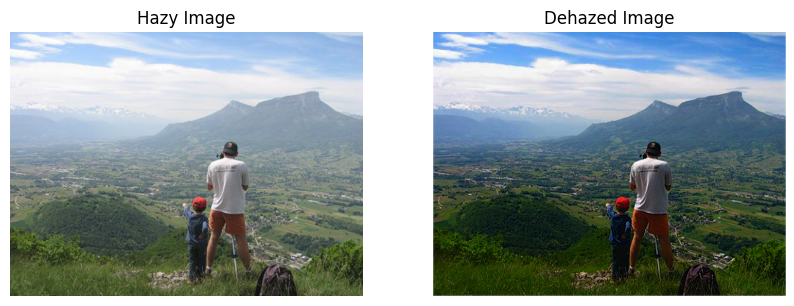

Dehazed image saved at results/test1.jpg
./test_images/test1.jpg done!


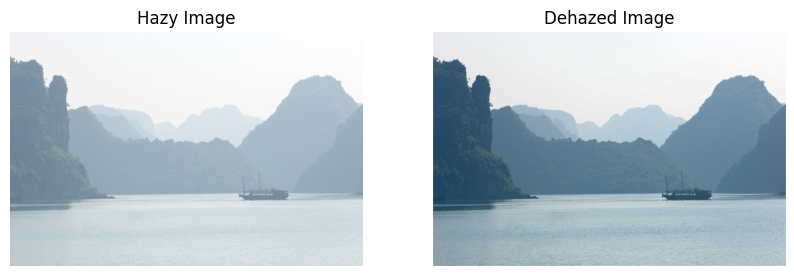

Dehazed image saved at results/test4.jpg
./test_images/test4.jpg done!


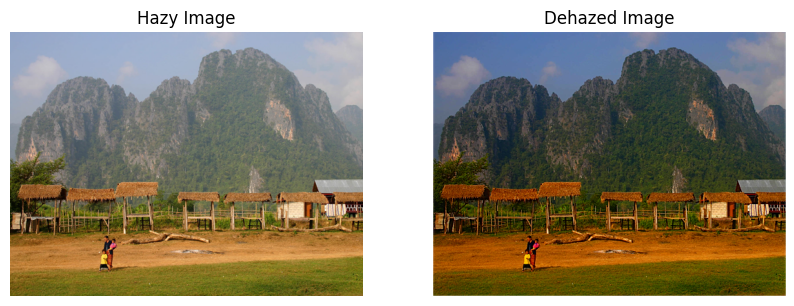

Dehazed image saved at results/test5.jpg
./test_images/test5.jpg done!


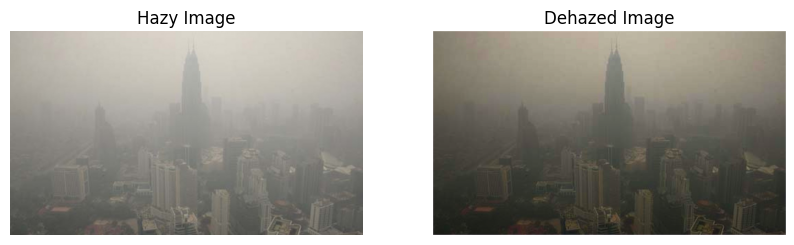

Dehazed image saved at results/test3.jpg
./test_images/test3.jpg done!


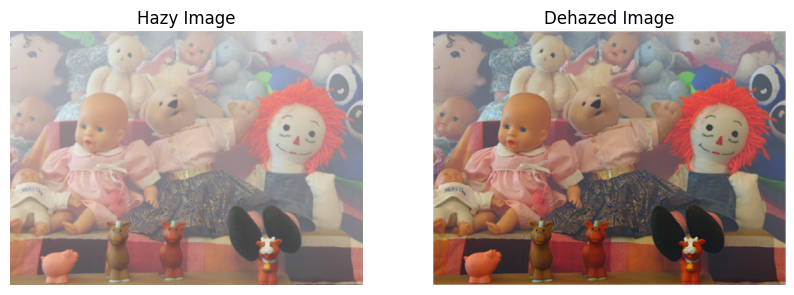

Dehazed image saved at results/test2.jpg
./test_images/test2.jpg done!


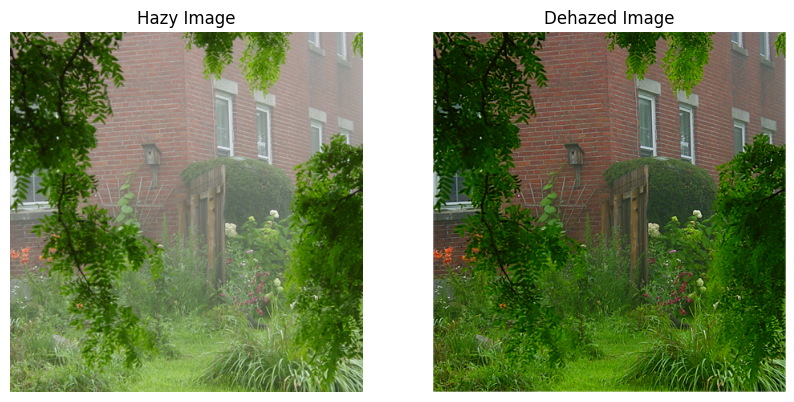

Dehazed image saved at results/test6.jpg
./test_images/test6.jpg done!


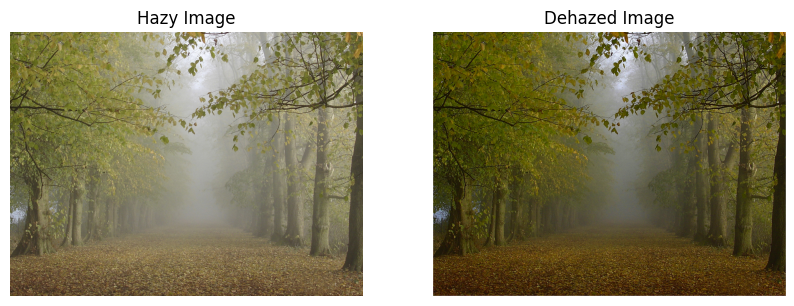

Dehazed image saved at results/test.jpg
./test_images/test.jpg done!


In [ ]:
test_list = glob.glob("./test_images/*")

for image in test_list:
	test_dehaze_image(image)
	print(image, "done!")